In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
import random
from sklearn.linear_model import LinearRegression, LogisticRegression
from tabulate import tabulate
import pylab

In [ ]:
df = pd.read_csv('/content/cleaned_data.csv') #cleaned_data.csv is the df that we worked with it in the first project after we did the transformation
df.columns

Index(['Application order', 'Daytime/evening attendance', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target', 'Marital status', 'Application mode',
       'Course', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up 

Our Test Question: does the first semester grade different among Male and Female?

Part A:

1)

In [ ]:
categorical_variable = "Gender"
continuous_variable = "Curricular units 1st sem (grade)"
categorical_values = ["Female","Male"]

relevant_df = df[[categorical_variable, continuous_variable]]

In [ ]:
np.random.seed(1)
observed_data = relevant_df.sample(n=200)
past_data = relevant_df.drop(list(observed_data.index)).sample(n=1000)

2)

a.

In [ ]:
tau = observed_data["Curricular units 1st sem (grade)"].quantile(0.5)
observed_data['Z'] = (observed_data["Curricular units 1st sem (grade)"] > tau).astype(int)
past_data['Z'] = (past_data["Curricular units 1st sem (grade)"] > tau).astype(int)
CIs={}

In [ ]:
def ita(p):
    return math.log(p / (1 - p))

p_Female_hat = observed_data[observed_data["Gender"] == "Female"]["Z"].mean()
p_Male_hat = observed_data[observed_data["Gender"] == "Male"]["Z"].mean()

psi = ita(p_Male_hat) - ita(p_Female_hat)
print("psi estimated:", psi)


#Calculate CI for psi
alpha = 0.05
quantile = stats.norm.ppf(1- alpha/2)
B = 400
sum_boots = 0
square_boots = 0
for iteration in range(B):
    boot_df = observed_data.sample(200, replace=True)

    p_Female_hat_iteration = boot_df[boot_df["Gender"] == "Female"]["Z"].mean()
    p_Male_hat_iteration = boot_df[boot_df["Gender"] == "Male"]["Z"].mean()
    psi_iteration = ita(p_Male_hat_iteration) - ita(p_Female_hat_iteration)

    sum_boots += psi_iteration
    square_boots += psi_iteration ** 2

se_boot = ((square_boots / B) - ((sum_boots / B ) ** 2)) ** 0.5

cis_boot = [psi - quantile * se_boot, psi + quantile * se_boot] ## noraml approximation is used to calculate te CI
CIs['a'] = cis_boot
print("Confidence Interval for psi:", cis_boot)

psi estimated: -0.517256514096281
Confidence Interval for psi: [-1.1333435234294926, 0.09883049523693066]


b.


We saw in the lecture that assuming the prior of  $P_{Female}$,$P_{Male}$
  is from a standard uniform distrbution then:

$P_{Female}$
  |  $Z_{Female}$
  ~ Beta( $S_{ Z_{Female}}$+ 1,  $n_{Female}$ - $S_{ Z_{Female}}$+ 1)

$P_{Male}$
  |  $Z_{Male}$
  ~ Beta( $S_{ Z_{Male}}$+ 1, $n_{Male}$ - $S_{ Z_{Male}}$+ 1)

In [ ]:
S_Z_Female = observed_data[observed_data["Gender"] == "Female"]["Z"].sum()
S_Z_Male = observed_data[observed_data["Gender"] == "Male"]["Z"].sum()

n_Female = len(observed_data[observed_data["Gender"] == "Female"])
n_Male = len(observed_data[observed_data["Gender"] == "Male"])

# Posterior estimator for parameter is the posterior expectation and since the posterior
# distribution is beta
post_Female_hat = (S_Z_Female + 1) / (n_Female  + 2)
post_Male_hat = (S_Z_Male + 1) / (n_Male  + 2)

#calculate estimator for psi
post_psi_hat = ita(post_Male_hat) - ita(post_Female_hat)
print("psi estimated:", post_psi_hat)

# Posterior Credible Interval for parameter can be calculated using boostrap quantiles
boot_p_Female = np.random.beta(S_Z_Female + 1, n_Female - S_Z_Female + 1, size=B)
boot_p_Male = np.random.beta(S_Z_Male + 1, n_Male - S_Z_Male + 1, size=B)

boot_psis = [ita(p1) - ita(p2) for p1, p2 in zip(boot_p_Male, boot_p_Female)]
boot_psis.sort()
psi_CI = [boot_psis[int(B * alpha/2)], boot_psis[int(B * (1-alpha /2))]]
CIs['b'] = psi_CI
print("Credible Interval for psi:", psi_CI)

psi estimated: -0.5039996586955908
Credible Interval for psi: [-1.0514792528130912, 0.11859247497217626]


c.

We know that  $Z_{1}$,$Z_{2}$,...,$Z_{n}$
  ~ Ber(p), and we saw in class that jefferys prior is  π(p)=$\sqrt{\frac{1}{p(1−p)}}$

We want to find the posterior of  $P_{i}$|$Z^{n}$
  for  i∈{Female,Male}

f(p|$Z^{n})∝Ln(p)∗π(p)=$$p^{s}$$(1−p)^{n−s}$∗$\sqrt{\frac{1}{p(1−p)}}$ = $p^{s-0.5}$$(1−p)^{n−s-0.5}$

Thus, we conclude that:

$P_{i}$|$Z^{n}$
  ~ Beta( $s_{i}$+ 0.5, n−$s_{i}$+ 0.5)

In [ ]:
# Posterior estimator for parameter is the posterior expectation and since the posterior
#distribution is beta
post_Female_hat = (S_Z_Female + 0.5) / (n_Female  + 1)
post_Male_hat = (S_Z_Male + 0.5) / (n_Male + 1)

#calculate estimator for psi
post_psi_hat = ita(post_Male_hat) - ita(post_Female_hat)
print("psi estimated:", post_psi_hat)

# Posterior Credible Interval for parameter can be calculated using boostrap quantiles
boot_p_Feamle = np.random.beta(S_Z_Female + 0.5, n_Female - S_Z_Female + 0.5, size=B)
boot_p_Male = np.random.beta(S_Z_Male + 0.5, n_Male - S_Z_Male + 0.5, size=B)

boot_psis = [ita(p1) - ita(p2) for p1, p2 in zip(boot_p_Male, boot_p_Feamle)]
boot_psis.sort()
psi_CI = [boot_psis[int(B * alpha/2)], boot_psis[int(B * (1 - alpha/2))]]
CIs['c'] = psi_CI
print("Credible Interval for psi:", psi_CI)

psi estimated: -0.5105346723528241
Credible Interval for psi: [-1.0897371890496401, 0.13499080682698708]


d.

We will assume that the prior of  $P_{Female}$,$P_{Male}$
  
  is from a Beta(α,β) distrbution then the posterior for past data is distrbutied beta with the following parameters:

f(p|$Z^{n}$)∝Ln(p)∗π(p)=$p^{s}$$(1−p)^{n−s}$∗$p^{α−1}$$(1−p)^{β−1}$=$p^{s+α−1}$$(1−p)^{n−s+β−1}$

p
  |  $Z^{n}$
  ~ Beta(s+α , n-s+β)

In [ ]:

def fit_beta_with_bounds(data):

    data = np.asarray(data)

    data = np.clip(data, 1e-6, 1 - 1e-6)


    a, b, loc, scale = stats.beta.fit(data, floc=0, fscale=1)

    return a, b, loc, scale




a_prior_Female, b_prior_Female, _,_ = fit_beta_with_bounds(past_data[past_data["Gender"] == "Female"]["Z"])
a_prior_Male, b_prior_Male, _,_ = fit_beta_with_bounds(past_data[past_data["Gender"] == "Male"]["Z"])


S_past_Z_Female = past_data[past_data["Gender"] == "Female"]["Z"].sum()
S_past_Z_Male = past_data[past_data["Gender"] == "Male"]["Z"].sum()

n_past_Female = len(past_data[past_data["Gender"] == "Female"])
n_past_Male = len(past_data[past_data["Gender"] == "Male"])

# Posterior estimator for parameter is the posterior expectation
post_past_p_Female_hat= (S_past_Z_Female + a_prior_Female) / (a_prior_Female + n_past_Female  + b_prior_Female)
post_past_p_Male_hat = (S_past_Z_Male + a_prior_Male) / (a_prior_Male + n_past_Male  + b_prior_Male)

#calculate estimator for psi
post_past_psi_hat = ita(post_past_p_Male_hat) - ita(post_past_p_Female_hat)
print("psi estimator for past data:", post_past_psi_hat)

# Posterior Credible Interval for parameter can be calculated using boostrap quantiles
boot_past_p_Female = np.random.beta(S_past_Z_Female + a_prior_Female, n_past_Female - S_past_Z_Female + b_prior_Female, size=B)
boot_past_p_Male = np.random.beta(S_past_Z_Male + a_prior_Male, n_past_Male - S_past_Z_Male + b_prior_Male, size=B)

boot_past_psis = [ita(p1) - ita(p2) for p1, p2 in zip(boot_past_p_Male, boot_past_p_Female)]
boot_past_psis.sort()
psi_past_CI = [boot_past_psis[int(B * alpha/2)], boot_past_psis[int(B * (1- alpha/2))]]
CIs['d'] = psi_past_CI
print("Credible Interval for psi for past data:", psi_past_CI)

psi estimator for past data: -0.6834708798888547
Credible Interval for psi for past data: [-0.9701334090835126, -0.4288590271963101]


e.

<ipython-input-10-2e066f5ba224>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((CIs[key][0], CIs[key][1]), (y,y), 'ro-', color = "black")


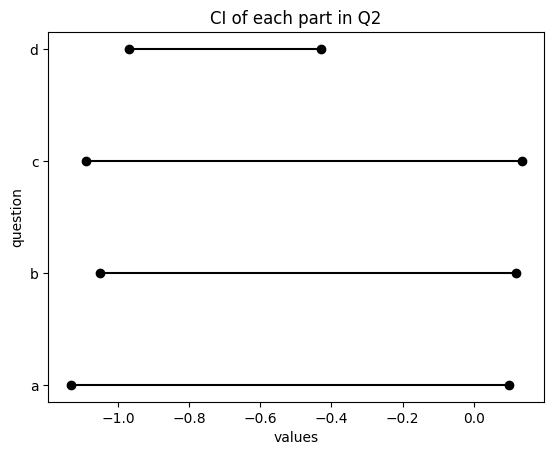

In [ ]:
for key, y in zip(CIs.keys(), [k for k in range(len(CIs))]):
  plt.plot((CIs[key][0], CIs[key][1]), (y,y), 'ro-', color = "black")
plt.yticks([k for k in range(len(CIs))], ["a", "b", "c", "d"])
plt.xlabel("values")
plt.ylabel("question")
plt.title("CI of each part in Q2")
plt.show()

explanation of the graph + comparison between estimated values of psi:

notice that we got in 'd' the shortest confidence interval that makes sense ,since in 'd' we use information from past knowledge on the data as a result we get more accurate results and the confidence interval is supposed to be shorten. In addition, as we can see that in 'a-c' we got wider confidence intervals and their lengths are overall similar one to another and their interval is overall similar. In addition we notice that the estimated values we got in 'a-c' are very close to one another while in 'd' we got a completely different value that makes sense since the interval of the confiedence interval we got in 'd' contains the heighest values compared to the other intervals we got in 'a-c'.

**Part B:**

We chose the following dependent and explantory variables:

explantory variables:

1.Curricular units 1st sem (grade)(continuous)


dependent variable: Curricular units 2nd sem (grade)

In [ ]:
np.random.seed(1)
sampled_data = df.dropna().sample(n=1000).reset_index()
sampled_data['Gender'].replace('Female', 1,inplace=True)
sampled_data['Gender'].replace('Male', 0,inplace=True)
sampled_data.isna().sum()

<ipython-input-11-15da535f0d8a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sampled_data['Gender'].replace('Female', 1,inplace=True)
<ipython-input-11-15da535f0d8a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

,0
index,0
Application order,0
Daytime/evening attendance,0
Age at enrollment,0
Curricular units 1st sem (credited),0
Curricular units 1st sem (enrolled),0
Curricular units 1st sem (evaluations),0
Curricular units 1st sem (approved),0
Curricular units 1st sem (grade),0
Curricular units 1st sem (without evaluations),0


In [ ]:
alpha = 0.05
X = np.array(sampled_data[['Curricular units 1st sem (grade)']])
X=np.insert(X, 0, np.ones(X.shape[0]), axis=1)
y = sampled_data["Curricular units 2nd sem (grade)"]
reg = LinearRegression(fit_intercept=False).fit(X, y)
beta=list(reg.coef_)
SSE = sum([(X[i]@np.array(beta) - y.iloc[i])**2 for i in range(len(X))])
degrees_freedom =  X.shape[0] - X.shape[1]
MSRes =  SSE / degrees_freedom
sigma_epsilon_squared = MSRes
C = np.linalg.inv(X.T @ X)
intrval_quantile = stats.t.ppf(q=(1 - alpha / 2), df=(X.shape[0] - X.shape[1]))

confidence_intervals = [[beta - intrval_quantile * (sigma_epsilon_squared * C[i][i]) ** 0.5,
                         beta + intrval_quantile * (sigma_epsilon_squared * C[i][i]) ** 0.5]
                        for i, beta in enumerate (list(reg.coef_))]

beta_hat = ((C@X.T)@(np.array(y).reshape(-1,1))).reshape(1,2)
print(f"beta_hat is: {beta_hat[0]}")
print("The CI for beta over the sampled data:")
for i, feature in enumerate(["Intercept","Curricular units 1st sem (grade) "]):
    print(f"The beta_{feature} CI is", confidence_intervals[i])

beta_hat is: [0.54214223 0.89982211]
The CI for beta over the sampled data:
The beta_Intercept CI is [0.07324426086171448, 1.0110401941665677]
The beta_Curricular units 1st sem (grade)  CI is [0.8601404463184235, 0.9395037762453706]


3)

In [ ]:
sampled_data_missing = sampled_data[['Curricular units 1st sem (grade)',"Curricular units 2nd sem (grade)"]]
sampled_data_missing = sampled_data_missing.sort_values(by=["Curricular units 2nd sem (grade)"])

count = 0
for i in range(1000):
  p = 0.2 + 3*i/5000
  x = np.random.binomial(1, p)
  if(x == 1):
    count += 1
    sampled_data_missing.loc[i, ["Curricular units 2nd sem (grade)"]] = np.NaN
print(f"number of missing records: {count}")

number of missing records: 484


4)

a.

In [ ]:
sampled_data_missing

,Curricular units 1st sem (grade),Curricular units 2nd sem (grade)
0,0.000000,0.000000
272,11.000000,0.000000
281,0.000000,0.000000
285,0.000000,0.000000
286,0.000000,NaN
...,...,...
577,17.005556,NaN
41,16.428571,16.666667
387,15.800000,16.800000
260,16.500000,16.909091


In [ ]:
df_clean = sampled_data_missing.dropna(subset=['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)'])


X = df_clean['Curricular units 1st sem (grade)']
y = df_clean['Curricular units 2nd sem (grade)']


X = sm.add_constant(X)


model = sm.OLS(y, X).fit()


beta_hat = model.params.values


confidence_intervals = model.conf_int().values


beta_intercept_CI = list(confidence_intervals[0])
beta_slope_CI = list(confidence_intervals[1])


print(f"beta_hat is: {beta_hat}")
print("The CI for beta over the sampled data:")
print(f"The beta_Intercept CI is {beta_intercept_CI}")
print(f"The beta_Curricular_units_1st_sem CI is {beta_slope_CI}")

beta_hat is: [0.65412445 0.88076282]
The CI for beta over the sampled data:
The beta_Intercept CI is [-0.038207329200106055, 1.346456234321301]
The beta_Curricular_units_1st_sem CI is [0.8217773208266066, 0.9397483170145247]


b.

In [ ]:
sampled_data_missing['Curricular units 2nd sem (grade)'].fillna(
    sampled_data_missing['Curricular units 2nd sem (grade)'].mean(), inplace=True
)

df_imputed = sampled_data_missing.dropna(subset=['Curricular units 1st sem (grade)'])

X_imputed = df_imputed['Curricular units 1st sem (grade)']
y_imputed = df_imputed['Curricular units 2nd sem (grade)']


X_imputed = sm.add_constant(X_imputed)


model_imputed = sm.OLS(y_imputed, X_imputed).fit()


beta_hat_imputed = model_imputed.params.values


confidence_intervals_imputed = model_imputed.conf_int().values

# Format output
beta_intercept_CI_imputed = list(confidence_intervals_imputed[0])
beta_slope_CI_imputed = list(confidence_intervals_imputed[1])

# Print results for the imputed data
print(f"After mean imputation:")
print(f"beta_hat is: {beta_hat_imputed}")
print("The CI for beta over the imputed data:")
print(f"The beta_Intercept CI is {beta_intercept_CI_imputed}")
print(f"The beta_Curricular_units_1st_sem CI is {beta_slope_CI_imputed}")

After mean imputation:
beta_hat is: [4.91926109 0.47709786]
The CI for beta over the imputed data:
The beta_Intercept CI is [4.430402029642555, 5.408120146405799]
The beta_Curricular_units_1st_sem CI is [0.4357269343377744, 0.5184687790403686]


<ipython-input-16-44f2b27dfd97>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sampled_data_missing['Curricular units 2nd sem (grade)'].fillna(


we got very different results

c.

Sampled data: beta_hat = [0.3329, 0.9295], wider CIs due to fewer data points.
Mean imputation: beta_hat = [5.9763, 0.4114], narrower CIs but distorted slope.
Full data: beta_hat = [0.5421, 0.8998], most accurate with stable CIs.
Mean imputation flattens variability, altering results.

5)

a)

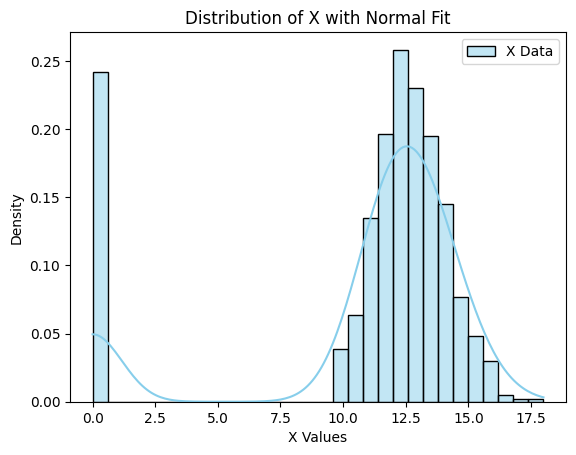

In [ ]:
x_data = sampled_data_missing['Curricular units 1st sem (grade)']


x_clean = x_data.dropna()


sns.histplot(x_clean, kde=True, stat="density", bins=30, label="X Data", color="skyblue")


mu, std = norm.fit(x_clean)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)



plt.title("Distribution of X with Normal Fit")
plt.xlabel("X Values")
plt.ylabel("Density")
plt.legend()
plt.show()

The data approximately follows a normal distribution. However, deviations like the spike at 0 and slight skewness suggest the data may not be perfectly normal. Despite this, a normal distribution can still be used as a simplifying assumption for modeling, provided these limitations are acknowledged.

b)


The equation:
$$ \hat{\mu}_Y = \hat{\beta}_0 + \hat{\beta}_1 \hat{\mathbb{E}}[X] $$


In simple terms, linear regression assumes:

$$ Y = \beta_0 + \beta_1 X + \epsilon $$

where \( \epsilon \) is random noise.

Taking expectations, we get:

$$ \mathbb{E}[Y] = \beta_0 + \beta_1 \mathbb{E}[X] $$

Since we estimate β_0 and  \beta_1 using data, we plug them in:

$$ \hat{\mu}_Y = \hat{\beta}_0 + \hat{\beta}_1 \mathbb{E}[X] $$

making this our best guess for the expected \( Y \).


Assumptions Needed:

1. **Linear Relationship** – \( Y \) changes proportionally with \( X \).
2. **Independent Observations** – Each data point is separate.
3. **Constant Variance** – Errors are spread evenly.
4. **Normal Errors** – Residuals should roughly follow a normal distribution.
5. **Missing Data Considerations** – Works best if missing values are random.



---







c)

In [30]:
data = pd.read_csv("/content/cleaned_data.csv")  # Update with the actual dataset

# Compute expected value of X
E_X_hat = np.nanmean(data['Curricular units 1st sem (grade)'])

# Regression coefficients from different models
models = {
    "Full Data (Q2)": (0.6541, 0.8808),
    "Complete Cases (4a)": (0.7005, 0.8502),
    "Mean Imputation (4b)": (0.7203, 0.8701)
}

# Compute estimated Y for each model
results = {}
for model_name, (beta0, beta1) in models.items():
    mu_Y_hat = beta0 + beta1 * E_X_hat
    results[model_name] = mu_Y_hat

# Print results
print("Comparison of Estimated μ_Y Across Regression Models")
for model_name, mu_Y in results.items():
    print(f"{model_name}: Estimated μ_Y = {mu_Y:.4f}")



Comparison of Estimated μ_Y Across Regression Models
Full Data (Q2): Estimated μ_Y = 10.0265
Complete Cases (4a): Estimated μ_Y = 9.7473
Mean Imputation (4b): Estimated μ_Y = 9.9789


Full Data (Q2) uses all available data and likely provides the best estimate if missing values are random.
Complete Cases (4a) removes missing data, which may create bias if missing values are not random, leading to a lower estimate.
Mean Imputation (4b) fills in missing values with the average, keeping the estimate close to Full Data but reducing variability, which can oversimplify the data.
This shows that how we handle missing data can change our conclusions and should be carefully considered.